# Problem 3

In [1]:
import PIL
import glob
import math
from random import uniform
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ParameterGrid
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

## Functions

In [2]:
def rotate(img, angle_deg):
    angle_rad = angle_deg * math.pi / 180
    rotate_img = img.rotate(angle_deg, PIL.Image.BILINEAR)
    sin, cos = abs(math.sin(angle_rad)), abs(math.cos(angle_rad))
    crop = 64 * (cos - sin)/(cos**2 - sin**2)
    upper = left = math.ceil((64-crop)/2)
    lower = right = math.ceil((64-crop)/2 + crop)
    rotate_img = rotate_img.crop(box=(left, upper, right, lower))
    rotate_img = rotate_img.resize((64, 64), PIL.Image.BILINEAR)
    return rotate_img

In [3]:
def scale(img, factor):
    crop = 64 * (1 - factor / 100)
    upper = left = math.ceil((64-crop)/2)
    lower = right = math.ceil((64-crop)/2 + crop)
    scale_img = img.crop(box=(left, upper, right, lower))
    scale_img = scale_img.resize((64, 64), PIL.Image.BILINEAR)
    return scale_img

In [4]:
def load_train(path,
               augmentation=0,
               max_rotate=30,
               max_scale=50):
    x, y = [], []
    for file in glob.glob(path + "**/*.jpg", recursive=True):
        img = Image.open(file)
        data = list((p, p, p) if isinstance(p, int) else tuple(p) for p in img.getdata())
        x.append(np.array(data).reshape(64, 64, 3))
        y.append(0 if "Cat" in file else 1)
        if augmentation > 0:
            for _ in range(augmentation):
                #scale
                scale_img = scale(img, uniform(1, max_scale))
                data = list((p, p, p) if isinstance(p, int) else tuple(p) for p in img.getdata())
                x.append(np.array(data).reshape(64, 64, 3))
                y.append(0 if "Cat" in file else 1)
                #rotate
                rotate_img = rotate(img, uniform(-max_scale, max_scale))
                data = list((p, p, p) if isinstance(p, int) else tuple(p) for p in img.getdata())
                x.append(np.array(data).reshape(64, 64, 3))
                y.append(0 if "Cat" in file else 1)
    x = np.asarray(x).swapaxes(1, 3).swapaxes(2, 3).astype("float32") / 255.
    y = np.asarray(y).reshape(-1, 1)
    return x, y

Note it is not the best way to call *augmentation_size* times the function *scale* and *rotate* (see [here](https://wiki.python.org/moin/PythonSpeed/PerformanceTips)), but it is easier to understand.

We should not do data augmentation on the validation set (to be confirm).

## Model

In [56]:
class Net(nn.Module):
    def __init__(self,
                 activation=nn.ReLU(),
                 n_filters=(8, 16, 32),
                 linear_size=100):
        super(Net, self).__init__()
        self.activation = activation
        self.n_filters = n_filters
        self.linear_size = linear_size
        self.conv = nn.Sequential(
            nn.Conv2d(
                3, self.n_filters[0], kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(2, 2), self.activation,
            nn.Conv2d(
                self.n_filters[0],
                self.n_filters[1],
                kernel_size=3,
                stride=1,
                padding=1), nn.MaxPool2d(2, 2), self.activation,
            nn.Conv2d(
                self.n_filters[1], self.n_filters[2], kernel_size=5, stride=1),
            nn.MaxPool2d(3, 3), self.activation)

        self.mlp = nn.Sequential(
            nn.Linear(self.n_filters[2] * 4 * 4, self.linear_size),
            self.activation, nn.Linear(self.linear_size, 1))

    def forward(self, x):
        x = self.conv(x)
        x = torch.sigmoid(self.mlp(x.view(-1, self.n_filters[2] * 4 * 4)))
        return x

    def evaluate(self, loader):
        with torch.no_grad():
            val_loss, correct, total = 0, 0, 0
            for data in loader:
                # get the inputs
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                ouputs = self(inputs)
                val_loss += criterion(ouputs, labels).item()
                total += labels.size(0)
                predicted = (ouputs > 0.5).float()
                correct += (predicted == labels).sum().item()
        return val_loss / len(loader), correct / total

    def predict(self, loader):
        predictions = []
        with torch.no_grad():
            for inputs in loader:
                inputs = inputs.to(device)
                ouputs = self(inputs)
                predictions.extend((ouputs > 0.5).float().cpu().numpy())
        return np.asarray(predictions).reshape(-1)

    def train(self,
              trainloader,
              validloader,
              patience=10,
              max_it=9999,
              verbose=True):
        counter, best_val_acc, train_loss, val_loss = 0, -1, None, None
        history = ([], [], [])
        if verbose:
            print("{:5s} | {:10s} | {:10s} | {:10s}".format(
                "epoch", "train_loss", "valid_loss", "valid_acc"))
        for epoch in range(max_it):
            running_loss = 0
            # early stopping
            counter += 1
            # decay lr after 2 epochs
            if epoch > 1:
                scheduler.step()
            if counter > patience - 1:
                break
            for i, data in enumerate(trainloader, 1):
                # get the inputs
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                # zero the parameter gradients
                optimizer.zero_grad()
                # forward + backward + optimize
                outputs = self.forward(inputs)
                train_loss = criterion(outputs, labels)
                running_loss += train_loss.item()
                train_loss.backward()
                optimizer.step()
            val_loss, val_acc = self.evaluate(validloader)
            if verbose:
                print(
                    "{:5d} | {:10.5f} | {:10.5f} | {:10.2%}".format(
                        epoch, running_loss / len(trainloader), val_loss,
                        val_acc),
                    end="")
            if val_acc > best_val_acc:
                counter = 0
                best_val_acc = val_acc
                torch.save(self.state_dict(), "best_model")
                if verbose:
                    print("\tsaved!", end="")
            if verbose:
                print("")
            history[0].append(running_loss / len(trainloader))
            history[1].append(val_loss)
            history[2].append(val_acc)
        self.load_state_dict(torch.load("best_model"))
        return history

## Load data (without augmentation)

In [6]:
x, y = load_train("data/kaggle/trainset/", augmentation=0)

x_train, x_valid, y_train, y_valid = train_test_split(
    x, y, test_size=0.1, stratify=y)

x_train = torch.from_numpy(x_train).float()
y_train = torch.from_numpy(y_train).float()
x_valid = torch.from_numpy(x_valid).float()
y_valid = torch.from_numpy(y_valid).float()

train = torch.utils.data.TensorDataset(x_train, y_train)
trainloader = torch.utils.data.DataLoader(train, batch_size=128, shuffle=True)

valid = torch.utils.data.TensorDataset(x_valid, y_valid)
validloader = torch.utils.data.DataLoader(valid, batch_size=128, shuffle=True)

## Train one model (sanity check)

In [7]:
model = Net()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
print("Let\'s use {}".format(device))

Let's use cuda:0


In [8]:
# define loss, optimizer and lr decay globally (probably not the best way)
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, 0.9)

In [9]:
(train_loss, valid_loss, valid_acc) = model.train(trainloader, validloader)

epoch | train_loss | valid_loss | valid_acc 
    0 |    0.69268 |    0.69101 |     50.00%	saved!
    1 |    0.67399 |    0.63013 |     65.60%	saved!
    2 |    0.63130 |    0.61329 |     67.35%	saved!
    3 |    0.58455 |    0.57155 |     69.60%	saved!
    4 |    0.54425 |    0.54085 |     72.85%	saved!
    5 |    0.51539 |    0.52145 |     73.45%	saved!
    6 |    0.48965 |    0.50931 |     75.45%	saved!
    7 |    0.45851 |    0.49654 |     75.65%	saved!
    8 |    0.43198 |    0.50629 |     75.65%
    9 |    0.40612 |    0.49974 |     77.25%	saved!
   10 |    0.36549 |    0.49352 |     77.70%	saved!
   11 |    0.33755 |    0.49474 |     78.15%	saved!
   12 |    0.29319 |    0.56288 |     75.85%
   13 |    0.25111 |    0.58479 |     76.95%
   14 |    0.22006 |    0.60163 |     77.30%
   15 |    0.16944 |    0.76482 |     75.15%
   16 |    0.14147 |    0.74087 |     75.90%
   17 |    0.10953 |    0.90081 |     77.40%
   18 |    0.07520 |    0.93229 |     76.10%
   19 |    0.04896 |   

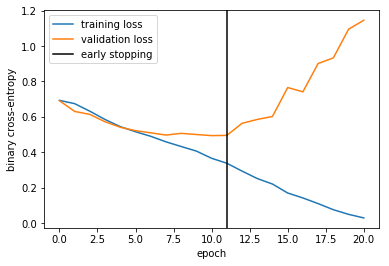

In [10]:
plt.plot(range(0, len(train_loss)), train_loss, label="training loss")
plt.plot(range(0, len(valid_loss)), valid_loss, label="validation loss")
plt.axvline(np.argmax(valid_acc), c="k", label="early stopping")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("binary cross-entropy")
plt.show()

The network start to overfit after 12 epochs. Early stopping + load the best model allows us to avoid this problem.

## Grid Search

In [11]:
best_params, best_model, best_val_acc = None, None, -1

param_grid = {
    "lr": [0.1, 0.01],
    "lr_decay": [0.99, 0.9, 0.5],
    "momentum": [0, 0.9],
    "activation": [nn.ReLU(), nn.Tanh()],
    "f": [4, 8, 16],
    "linear_size": [100, 200],
    "batch_size": [128, 512]
}

for params in ParameterGrid(param_grid):
    trainloader = torch.utils.data.DataLoader(
        train, params["batch_size"], shuffle=True)
    validloader = torch.utils.data.DataLoader(
        valid, params["batch_size"], shuffle=True)
    n_filters = (params["f"], params["f"] * 2, params["f"] * 4)
    model = Net(params["activation"], n_filters, params["linear_size"])
    model.to(device)
    criterion = nn.BCELoss()
    optimizer = optim.SGD(model.parameters(), params["lr"],  params["momentum"])
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, params["lr_decay"])
    model.train(trainloader, validloader, verbose=False)
    val_acc = model.evaluate(validloader)[1]
    if val_acc > best_val_acc:
        best_model = model
        best_params = params
        best_val_acc = val_acc
        print("{}: {:.1%}".format(params, val_acc))

{'activation': ReLU(), 'batch_size': 128, 'f': 4, 'linear_size': 100, 'lr': 0.1, 'lr_decay': 0.99, 'momentum': 0}: 78.0%
{'activation': ReLU(), 'batch_size': 128, 'f': 4, 'linear_size': 200, 'lr': 0.01, 'lr_decay': 0.99, 'momentum': 0.9}: 78.1%
{'activation': ReLU(), 'batch_size': 128, 'f': 8, 'linear_size': 100, 'lr': 0.1, 'lr_decay': 0.9, 'momentum': 0.9}: 80.2%
{'activation': ReLU(), 'batch_size': 128, 'f': 16, 'linear_size': 100, 'lr': 0.01, 'lr_decay': 0.99, 'momentum': 0.9}: 80.8%
{'activation': Tanh(), 'batch_size': 128, 'f': 16, 'linear_size': 100, 'lr': 0.1, 'lr_decay': 0.5, 'momentum': 0.9}: 81.2%


We do not do a grid search on the data augmentation parameters because it would take too long to generate the data again. Also, we report only the models that improve on the previous best.

## Load data (with augmentation)

In [12]:
x, y = load_train("data/kaggle/trainset/", augmentation=3)

print(x.shape)

x_train, x_valid, y_train, y_valid = train_test_split(
    x, y, test_size=0.1, stratify=y)

x_train = torch.from_numpy(x_train).float()
y_train = torch.from_numpy(y_train).float()
x_valid = torch.from_numpy(x_valid).float()
y_valid = torch.from_numpy(y_valid).float()

## Train model with best hyperparameters

In [57]:
params = best_params
trainloader = torch.utils.data.DataLoader(
    train, params["batch_size"], shuffle=True)
validloader = torch.utils.data.DataLoader(
    valid, params["batch_size"], shuffle=True)
n_filters = (params["f"], params["f"] * 2, params["f"] * 4)
best_model = Net(best_params["activation"], n_filters, best_params["linear_size"])
best_model.to(device)
criterion = nn.BCELoss()
optimizer = optim.SGD(best_model.parameters(), params["lr"],  params["momentum"])
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, params["lr_decay"])
(train_loss, valid_loss, valid_acc) = best_model.train(trainloader, validloader)

epoch | train_loss | valid_loss | valid_acc 
    0 |    0.66743 |    0.63329 |     64.70%	saved!
    1 |    0.58704 |    0.54186 |     72.45%	saved!
    2 |    0.52285 |    0.49357 |     76.55%	saved!
    3 |    0.45101 |    0.45781 |     78.15%	saved!
    4 |    0.38773 |    0.46095 |     78.55%	saved!
    5 |    0.33345 |    0.44897 |     79.75%	saved!
    6 |    0.29224 |    0.47248 |     80.05%	saved!
    7 |    0.26171 |    0.47361 |     80.05%
    8 |    0.24523 |    0.47772 |     79.90%
    9 |    0.23736 |    0.47861 |     80.00%
   10 |    0.23218 |    0.48080 |     80.40%	saved!
   11 |    0.22978 |    0.48214 |     80.30%
   12 |    0.22837 |    0.47958 |     80.15%
   13 |    0.22780 |    0.48365 |     80.05%
   14 |    0.22744 |    0.47954 |     80.05%
   15 |    0.22700 |    0.48362 |     80.05%
   16 |    0.22708 |    0.47768 |     80.05%
   17 |    0.22726 |    0.48281 |     80.05%
   18 |    0.22714 |    0.48279 |     80.05%
   19 |    0.22723 |    0.47958 |     80.05%

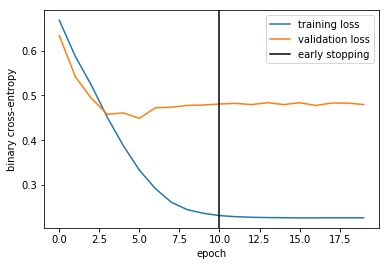

In [58]:
plt.plot(range(0, len(train_loss)), train_loss, label="training loss")
plt.plot(range(0, len(valid_loss)), valid_loss, label="validation loss")
plt.axvline(np.argmax(valid_acc), c="k", label="early stopping")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("binary cross-entropy")
plt.show()

In [59]:
x_test = []
for file in glob.glob("data/kaggle/testset/test/*.jpg"):
    img = Image.open(file)
    data = list((p, p, p) if isinstance(p, int) else tuple(p) for p in img.getdata())
    x_test.append(np.array(data).reshape(64, 64, 3))
x_test = np.asarray(x_test).swapaxes(1, 3).swapaxes(2, 3).astype("float32") / 255.
x_test = torch.from_numpy(x_test).float()
testloader = torch.utils.data.DataLoader(x, 1024, shuffle=False)

In [60]:
predictions = best_model.predict(testloader)

In [67]:
import csv
file = open("predictions.csv", 'w')
writer = csv.writer(file, quoting=csv.QUOTE_NONE)
header = ["id,label"]
writer.writerow(header)
for i, p in enumerate(predictions,1):
    writer.writerow(["{},{}".format(i, "Cat" if p==0 else "Dog")])
file.close()

Error: need to escape, but no escapechar set